<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/GPAW_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

1. Install GPAW and JARVIS-Tools
2. Aluminum crystal structure abd energy calculation
3. Silicon bandstructure
4. Example JARVIS-Leaderboard contribution
5. Interface energy calculation


# 1. Installation

In [1]:
!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw jarvis-tools

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxc9
Suggested packages:
  cython-doc python3-numpy
The following NEW packages will be installed:
  cython3 gpaw-data libxc-dev libxc9 python3-mpi4py
0 upgraded, 5 newly installed, 0 to remove and 45 not upgraded.
Need to get 66.5 MB of archives.
After this operation, 102 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cython3 amd64 0.29.28-1ubuntu3 [1,336 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 gpaw-data all 0.9.20000-2 [52.7 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxc9 amd64 5.1.7-1ubuntu1 [3,900 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxc-dev amd64 5.1.7-1ubuntu1 [8,038 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-mpi4py amd64 3.1.3-1build2 [465 kB]
Fetched 66.5 MB in 6s (11.0 

In [2]:
!gpaw test

 -------------------------------------------------------------------------------------------------
| python-3.10.12    /usr/bin/python3                                                              |
| gpaw-24.1.0       /usr/local/lib/python3.10/dist-packages/gpaw/                                 |
| ase-3.22.1        /usr/local/lib/python3.10/dist-packages/ase/                                  |
| numpy-1.25.2      /usr/local/lib/python3.10/dist-packages/numpy/                                |
| scipy-1.11.4      /usr/local/lib/python3.10/dist-packages/scipy/                                |
| libxc-5.1.7       yes                                                                           |
| _gpaw             /usr/local/lib/python3.10/dist-packages/_gpaw.cpython-310-x86_64-linux-gnu.so |
| MPI enabled       yes                                                                           |
| OpenMP enabled    no                                                                            |
|

In [3]:
!gpaw info

 -------------------------------------------------------------------------------------------------
| python-3.10.12    /usr/bin/python3                                                              |
| gpaw-24.1.0       /usr/local/lib/python3.10/dist-packages/gpaw/                                 |
| ase-3.22.1        /usr/local/lib/python3.10/dist-packages/ase/                                  |
| numpy-1.25.2      /usr/local/lib/python3.10/dist-packages/numpy/                                |
| scipy-1.11.4      /usr/local/lib/python3.10/dist-packages/scipy/                                |
| libxc-5.1.7       yes                                                                           |
| _gpaw             /usr/local/lib/python3.10/dist-packages/_gpaw.cpython-310-x86_64-linux-gnu.so |
| MPI enabled       yes                                                                           |
| OpenMP enabled    no                                                                            |
|

# 2. FCC Aluminum

Single point calculation

In [4]:
%%time
# Sample calculation from https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/structureoptimization/aluminium/aluminium.html
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW

name = 'Al-fcc'
a = 4.05  # fcc lattice parameter
b = a / 2

bulk = Atoms('Al',
             cell=[[0, b, b],
                   [b, 0, b],
                   [b, b, 0]],
             pbc=True)

view(bulk)

k = 4
calc = GPAW(mode=PW(300),       # cutoff
            kpts=(k, k, k),     # k-points
            txt=name + '.txt')  # output file

bulk.calc = calc

energy = bulk.get_potential_energy()
calc.write(name + '.gpw')
print('Energy:', energy, 'eV')

Energy: -4.122151616078063 eV
CPU times: user 2.33 s, sys: 1.41 s, total: 3.75 s
Wall time: 2.76 s


Geometry optimization

In [9]:
from ase import Atoms
from ase.build import bulk
from ase.io import write
from ase.units import GPa
from gpaw import GPAW, PW
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.eos import EquationOfState
from jarvis.core.atoms import ase_to_atoms
# Set up bulk aluminum
aluminum = bulk('Al', 'fcc', a=4.05)
print('Init',ase_to_atoms(aluminum))
# GPAW calculator setup
calc = GPAW(mode=PW(500),  # Plane wave cutoff
            xc='PBE',      # Exchange-correlation functional
            kpts=(6, 6, 6), # k-points
            convergence={'energy': 1e-6, 'density': 1e-4, 'eigenstates': 1e-8},
            txt='aluminum_gpaw.txt')

aluminum.set_calculator(calc)

# Relax the structure
uf = UnitCellFilter(aluminum)
opt = BFGS(uf)
opt.run(fmax=0.01)

print('Final',ase_to_atoms(aluminum))


Init System
1.0
0.0 2.025 2.025
2.025 0.0 2.025
2.025 2.025 0.0
Al 
1 
direct
0.0 0.0 0.0 Al

      Step     Time          Energy         fmax
BFGS:    0 16:10:30       -3.730177        0.0436
BFGS:    1 16:10:36       -3.730252        0.0285
BFGS:    2 16:10:41       -3.730316        0.0003
Final System
1.0
-1.1382799519927317e-17 2.021351446312309 2.0213514463123086
2.021351446312309 -1.9507955268131013e-18 2.021351446312309
2.021351446312309 2.021351446312309 -1.8036985343423936e-17
Al 
1 
direct
-6.81137054404624e-20 6.237049310841029e-20 -6.237049310841048e-20 Al



In [11]:
initial_stress=aluminum.get_stress()
initial_stress

array([-1.78617772e-05, -1.78617772e-05, -1.78617772e-05, -8.29557123e-19,
        0.00000000e+00, -1.03694640e-18])

In [17]:
from tqdm import tqdm
import numpy as np
j_atoms = ase_to_atoms(aluminum)
strains = np.arange(0, 0.5, 0.01)
stresses = []
for i in tqdm(strains):
  atoms=j_atoms.strain_atoms([i,0,0]).ase_converter()
  atoms.calc=calc
  final_stress = atoms.get_stress()
  stress=160*(final_stress-initial_stress)/i
  print(i,stress,final_stress[0])
  stresses.append(final_stress[0])



  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-17-049bc26a0d60>:10: RuntimeWarning: invalid value encountered in divide
  stress=160*(final_stress-initial_stress)/i
  2%|▏         | 1/50 [00:08<06:57,  8.52s/it]

0.0 [nan nan nan nan nan nan] -1.786177718643607e-05


  4%|▍         | 2/50 [00:18<07:24,  9.26s/it]

0.01 [2.36794024e+01 1.02298700e+02 1.02298700e+02 3.81596277e-14
 0.00000000e+00 1.65911425e-14] 0.0014621008702745042


  6%|▌         | 3/50 [00:28<07:31,  9.60s/it]

0.02 [5.92054886e+01 8.04742481e+01 8.04742481e+01 2.65458279e-14
 1.99093710e-14 4.81143131e-14] 0.007382824294871958


  8%|▊         | 4/50 [00:39<07:50, 10.23s/it]

0.03 [ 8.30441310e+01  6.39723934e+01  6.39723934e+01  1.43789901e-14
 -1.32729140e-14  5.53038082e-15] 0.015552912793835702


 10%|█         | 5/50 [00:50<07:49, 10.42s/it]

0.04 [8.72631001e+01 5.68304162e+01 5.68304162e+01 2.19832638e-14
 9.95468548e-15 4.14778561e-15] 0.021797913235594525


 12%|█▏        | 6/50 [01:00<07:38, 10.42s/it]

0.05 [8.83299800e+01 5.22345808e+01 5.22345808e+01 1.01205969e-14
 0.00000000e+00 3.31822849e-15] 0.027585256962103108


 14%|█▍        | 7/50 [01:10<07:23, 10.31s/it]

0.06 [8.85328373e+01 4.88570274e+01 4.88570274e+01 1.00929450e-14
 0.00000000e+00 2.76519041e-15] 0.03318195221227759


 16%|█▌        | 8/50 [01:22<07:28, 10.68s/it]

0.07 [ 8.19684959e+01  4.87064231e+01  4.87064231e+01  1.09620048e-14
  0.00000000e+00 -3.31822849e-15] 0.035843355170156604


 18%|█▊        | 9/50 [01:34<07:37, 11.16s/it]

0.08 [7.35554943e+01 4.95022489e+01 4.95022489e+01 1.12249448e-14
 0.00000000e+00 2.07389281e-15] 0.03675988536266062


 20%|██        | 10/50 [01:43<06:55, 10.38s/it]

0.09 [6.96840498e+01 4.84217442e+01 4.84217442e+01 1.57500637e-14
 0.00000000e+00 1.06920696e-14] 0.039179416228825224


 22%|██▏       | 11/50 [01:53<06:44, 10.38s/it]

0.1 [ 6.85643309e+01  4.63268604e+01  4.63268604e+01  1.01154122e-14
 -3.98187419e-15  1.65911425e-15] 0.042834845029326406


 24%|██▍       | 12/50 [02:02<06:23, 10.09s/it]

0.11 [ 6.64695684e+01  4.47386816e+01  4.47386816e+01  9.57761406e-15
 -3.61988563e-15  1.50828568e-15] 0.045679966491372286


 26%|██▌       | 13/50 [02:10<05:49,  9.46s/it]

0.12 [ 6.31304994e+01  4.37971695e+01  4.37971695e+01  9.92012060e-15
 -3.31822849e-15  1.38259520e-15] 0.047330012770718057


 28%|██▊       | 14/50 [02:20<05:39,  9.44s/it]

0.13 [ 6.06543234e+01  4.26277042e+01  4.26277042e+01  7.91269871e-15
 -3.06298015e-15  1.27624173e-15] 0.04926377595180177


 30%|███       | 15/50 [02:29<05:32,  9.50s/it]

0.14 [ 6.03348424e+01  4.06302825e+01  4.06302825e+01  8.76960387e-15
 -2.84419585e-15 -1.65911425e-15] 0.05277512536555883


 32%|███▏      | 16/50 [02:37<05:06,  9.03s/it]

0.15 [ 6.13908471e+01  3.80711387e+01  3.80711387e+01  8.01905219e-15
 -2.65458279e-15  1.10607616e-15] 0.05753605738161671


 34%|███▍      | 17/50 [02:47<05:00,  9.10s/it]

0.16 [ 6.21488464e+01  3.56570482e+01  3.56570482e+01  6.58460966e-15
 -2.48867137e-15  1.03694640e-15] 0.06213098461216861


/usr/local/lib/python3.10/dist-packages/gpaw/utilities/gpts.py:44: UserWarning: Initial realspace grid (15,18,18) inconsistent with symmetries.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpaw/utilities/gpts.py:71: UserWarning: Using symmetrized grid: (18,18,18).

  warnings.warn('Using symmetrized grid: ({},{},{}).\n'.format(*N_c))
 36%|███▌      | 18/50 [02:58<05:16,  9.88s/it]

0.17 [ 6.13503341e+01  3.39727565e+01  3.39727565e+01  9.27152079e-15
 -2.34227894e-15  9.75949556e-16] 0.06516686815187035


 38%|███▊      | 19/50 [03:11<05:28, 10.60s/it]

0.18 [ 5.94562312e+01  3.28388244e+01  3.28388244e+01  9.30947438e-15
 -2.21215233e-15  9.21730137e-16] 0.06687039827828886


 40%|████      | 20/50 [03:22<05:23, 10.80s/it]

0.19 [ 5.77640709e+01  3.16520321e+01  3.16520321e+01  8.29557123e-15
 -2.09572326e-15  8.73218024e-16] 0.0685769724353295


 42%|████▏     | 21/50 [03:33<05:14, 10.83s/it]

0.2 [5.60396886e+01 3.05046091e+01 3.05046091e+01 7.13419126e-15
 3.98187419e-15 8.29557123e-16] 0.070031748962895


 44%|████▍     | 22/50 [03:44<05:09, 11.05s/it]

0.21 [5.33230787e+01 2.98752300e+01 2.98752300e+01 6.08341890e-15
 3.79226113e-15 7.90054403e-16] 0.0699686789522326


 46%|████▌     | 23/50 [03:56<05:03, 11.25s/it]

0.22 [4.97637290e+01 2.97503494e+01 2.97503494e+01 7.61684267e-15
 1.80994281e-15 7.54142839e-16] 0.06840726562997011


 48%|████▊     | 24/50 [04:08<04:56, 11.41s/it]

0.23 [4.64528020e+01 2.96408969e+01 2.96408969e+01 1.11809873e-14
 0.00000000e+00 1.11088519e-14] 0.0667580410957712


 50%|█████     | 25/50 [04:19<04:46, 11.47s/it]

0.24 [4.41634308e+01 2.91607960e+01 2.91607960e+01 5.73777010e-15
 3.31822849e-15 6.91297602e-16] 0.06622728435713289


 52%|█████▏    | 26/50 [04:31<04:38, 11.58s/it]

0.25 [4.28879241e+01 2.82784066e+01 2.82784066e+01 6.10554043e-15
 1.59274968e-15 6.63645698e-16] 0.06699451964951326


 54%|█████▍    | 27/50 [04:42<04:19, 11.26s/it]

0.26 [ 4.22456950e+01  2.71480288e+01  2.71480288e+01  9.69943713e-15
 -3.06298015e-15  9.82706130e-15] 0.06863139255711366


 56%|█████▌    | 28/50 [04:53<04:09, 11.34s/it]

0.27 [4.18788613e+01 2.59262519e+01 2.59262519e+01 8.41846858e-15
 2.94953644e-15 9.46309607e-15] 0.07065271663078097


 58%|█████▊    | 29/50 [05:05<04:00, 11.44s/it]

0.28 [4.15542773e+01 2.47175703e+01 2.47175703e+01 5.36249426e-15
 0.00000000e+00 5.92540802e-16] 0.07270212343496762


 60%|██████    | 30/50 [05:17<03:49, 11.47s/it]

0.29 [4.11390835e+01 2.35836637e+01 2.35836637e+01 5.00594816e-15
 0.00000000e+00 5.72108361e-16] 0.0745467269780254


 62%|██████▏   | 31/50 [05:28<03:40, 11.58s/it]

0.3 [4.05762841e+01 2.25539232e+01 2.25539232e+01 5.00499464e-15
 0.00000000e+00 5.53038082e-16] 0.0760626708359181


 64%|██████▍   | 32/50 [05:40<03:29, 11.65s/it]

0.31 [3.98783722e+01 2.16275052e+01 2.16275052e+01 4.60270404e-15
 0.00000000e+00 5.35198144e-16] 0.07724648428980617


 66%|██████▌   | 33/50 [05:51<03:14, 11.43s/it]

0.32 [ 3.90961002e+01  2.07858064e+01  2.07858064e+01  4.07001463e-15
 -1.24433568e-15  5.18473202e-16] 0.07817433859342399


 68%|██████▊   | 34/50 [06:03<03:03, 11.48s/it]

0.33 [ 3.82641260e+01  2.00103086e+01  2.00103086e+01  4.54999513e-15
 -1.20662854e-15  5.02761893e-16] 0.07890189813059464


 70%|███████   | 35/50 [06:15<02:54, 11.60s/it]

0.34 [ 3.73875418e+01  1.92992939e+01  1.92992939e+01  4.19658309e-15
 -1.17113947e-15  4.87974778e-16] 0.07943066448356853


 72%|███████▏  | 36/50 [06:27<02:43, 11.69s/it]

0.35000000000000003 [3.64357165e+01 1.86658977e+01 1.86658977e+01 4.07668072e-15
 0.00000000e+00 4.74032642e-16] 0.07968526798564246


 74%|███████▍  | 37/50 [06:38<02:32, 11.76s/it]

0.36 [ 3.53928356e+01  1.81174706e+01  1.81174706e+01  3.89430983e-15
  0.00000000e+00 -6.45211096e-16] 0.07961601833693524


 76%|███████▌  | 38/50 [06:50<02:21, 11.78s/it]

0.37 [ 3.42753500e+01  1.76435281e+01  1.76435281e+01  3.65453543e-15
 -5.38091107e-16  9.86500362e-16] 0.07924388519123954


 78%|███████▊  | 39/50 [07:02<02:09, 11.73s/it]

0.38 [ 3.31301777e+01  1.72211118e+01  1.72211118e+01  3.68934615e-15
 -5.23930815e-16  4.36609012e-16] 0.07866631036999922


 80%|████████  | 40/50 [07:13<01:54, 11.46s/it]

0.39 [ 3.20070523e+01  1.68227658e+01  1.68227658e+01  3.56284149e-15
 -1.02099338e-15  4.25413909e-16] 0.07799932814828901


 82%|████████▏ | 41/50 [07:24<01:43, 11.53s/it]

0.4 [ 3.09361464e+01  1.64296997e+01  1.64296997e+01  3.54376433e-15
 -4.97734274e-16  4.14778561e-16] 0.07732250421683755


/usr/local/lib/python3.10/dist-packages/gpaw/utilities/gpts.py:44: UserWarning: Initial realspace grid (15,20,20) inconsistent with symmetries.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpaw/utilities/gpts.py:71: UserWarning: Using symmetrized grid: (20,20,20).

  warnings.warn('Using symmetrized grid: ({},{},{}).\n'.format(*N_c))
 84%|████████▍ | 42/50 [07:37<01:35, 11.88s/it]

0.41000000000000003 [2.99202672e+01 1.60376605e+01 1.60376605e+01 3.39283805e-15
 9.71188827e-16 8.90256425e-16] 0.0766528228560053


 86%|████████▌ | 43/50 [07:50<01:24, 12.08s/it]

0.42 [2.89384362e+01 1.56549929e+01 1.56549929e+01 3.31668542e-15
 9.48065283e-16 8.69059843e-16] 0.07594553326571693


 88%|████████▊ | 44/50 [08:02<01:13, 12.21s/it]

0.43 [2.79614132e+01 1.53008236e+01 1.53008236e+01 3.25311790e-15
 9.26017254e-16 8.48849149e-16] 0.07512843624726083


 90%|█████████ | 45/50 [08:15<01:01, 12.26s/it]

0.44 [2.69679437e+01 1.49909852e+01 1.49909852e+01 3.17211332e-15
 9.04971407e-16 8.29557123e-16] 0.07414398338293483


 92%|█████████▏| 46/50 [08:28<00:50, 12.54s/it]

0.45 [2.59684844e+01 1.47230675e+01 1.47230675e+01 3.10853489e-15
 8.84860931e-16 1.25355299e-15] 0.0730185006278219


 94%|█████████▍| 47/50 [08:40<00:37, 12.55s/it]

0.46 [2.50037847e+01 1.44760125e+01 1.44760125e+01 3.03419535e-15
 8.65624824e-16 1.22630183e-15] 0.07186801916092095


 96%|█████████▌| 48/50 [08:56<00:26, 13.41s/it]

0.47000000000000003 [2.41204679e+01 1.42223311e+01 1.42223311e+01 3.03582607e-15
 8.47207275e-16 7.76606668e-16] 0.07083601264405459


 98%|█████████▊| 49/50 [09:08<00:13, 13.14s/it]

0.48 [2.33359101e+01 1.39483574e+01 1.39483574e+01 2.90777054e-15
 4.14778561e-16 1.17520592e-15] 0.06998986860126205


100%|██████████| 50/50 [09:21<00:00, 11.22s/it]

0.49 [2.26318843e+01 1.36587748e+01 1.36587748e+01 2.84842828e-15
 4.06313693e-16 1.15122213e-15] 0.06929228389857088


Text(0, 0.5, 'stress')

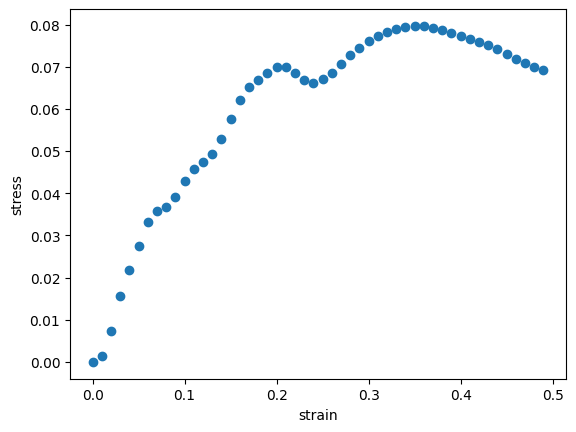

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(strains,stresses,'o')
plt.xlabel('strain')
plt.ylabel('stress')

In [ ]:
from jarvis.core.atoms import ase_to_atoms
ase_to_atoms(aluminum).get_conventional_atoms

System
1.0
4.0427 0.0 0.0
0.0 4.0427 0.0
0.0 0.0 4.0427
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.5 0.5 Al
0.5 0.0 0.5 Al
0.5 0.5 0.0 Al

In [ ]:
  from jarvis.core.atoms import Atoms
  from jarvis.io.vasp.inputs import Poscar
  pos=pos="""FCC Al
1.0
4.05 0.0 0.0
0.0 4.05 0.0
0.0 0.0 4.05
Al
4
direct
0.0 0.0 0.0
0.0 0.5 0.5
0.5 0.0 0.5
0.5 0.5 0.0
"""

j_atoms=Poscar.from_string(pos).atoms
atoms=j_atoms.ase_converter()


In [ ]:
from ase.stress import full_3x3_to_voigt_6_stress, voigt_6_to_full_3x3_stress
from ase import units
atoms.calc=calc
stress_initial = atoms.get_stress()

In [ ]:
strain=0.001
#strained_atoms=j_atoms.strain_atoms([[strain,0,0],[0,1,0],[0,1,0]]).ase_converter()
strained_atoms=j_atoms.strain_atoms([strain,0,0]).ase_converter()
strained_atoms.calc=calc
stress_final = strained_atoms.get_stress() #strained_atoms.get_potential_energy(),

In [ ]:
stress_final

array([0.00268626, 0.00331238, 0.00331238, 0.        , 0.        ,
       0.        ])

In [ ]:
(stress_final-stress_initial)/strain/units.GPa

array([1.00187713e+01, 1.10334958e+02, 1.10334958e+02, 0.00000000e+00,
       0.00000000e+00, 9.96822771e-14])

In [ ]:
(voigt_6_to_full_3x3_stress(stress_final)-voigt_6_to_full_3x3_stress(stress_initial))/strain/units.GPa

array([[1.00187713e+01, 9.96822771e-14, 0.00000000e+00],
       [9.96822771e-14, 1.10334958e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.10334958e+02]])

In [ ]:
from tqdm import tqdm
import numpy as np
strains=np.arange(0,.5,0.05)
stresses=[]
for i in tqdm(strains,total=len(strains)):
  strained_atoms=j_atoms.strain_atoms([i,0,0]).ase_converter()
  strained_atoms.calc=calc
  stress_final = voigt_6_to_full_3x3_stress(strained_atoms.get_stress()) #strained_atoms.get_potential_energy(),
  print(i,stress_final)
  stresses.append(stress_final[0][0])

 10%|█         | 1/10 [00:10<01:32, 10.31s/it]

0.0 [[6.64399054e-02 2.07389281e-19 0.00000000e+00]
 [2.07389281e-19 6.64399054e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.64399054e-02]]


 20%|██        | 2/10 [00:17<01:07,  8.45s/it]

0.05 [[0.05916806 0.         0.        ]
 [0.         0.06677783 0.        ]
 [0.         0.         0.06677783]]


 30%|███       | 3/10 [00:24<00:54,  7.75s/it]

0.1 [[0.05386074 0.         0.        ]
 [0.         0.0665575  0.        ]
 [0.         0.         0.0665575 ]]


 40%|████      | 4/10 [00:32<00:47,  7.91s/it]

0.15000000000000002 [[0.05148467 0.         0.        ]
 [0.         0.06460132 0.        ]
 [0.         0.         0.06460132]]


 50%|█████     | 5/10 [00:39<00:37,  7.53s/it]

0.2 [[0.05085928 0.         0.        ]
 [0.         0.06119063 0.        ]
 [0.         0.         0.06119063]]


 60%|██████    | 6/10 [00:48<00:31,  7.97s/it]

0.25 [[0.05021029 0.         0.        ]
 [0.         0.05732173 0.        ]
 [0.         0.         0.05732173]]


 70%|███████   | 7/10 [00:56<00:24,  8.03s/it]

0.30000000000000004 [[0.04864177 0.         0.        ]
 [0.         0.0536694  0.        ]
 [0.         0.         0.0536694 ]]


 80%|████████  | 8/10 [01:05<00:16,  8.42s/it]

0.35000000000000003 [[0.04552276 0.         0.        ]
 [0.         0.05071422 0.        ]
 [0.         0.         0.05071422]]


 90%|█████████ | 9/10 [01:18<00:09,  9.85s/it]

0.4 [[0.04084067 0.         0.        ]
 [0.         0.04871094 0.        ]
 [0.         0.         0.04871094]]


100%|██████████| 10/10 [01:38<00:00,  9.86s/it]

0.45 [[0.03608635 0.         0.        ]
 [0.         0.04715854 0.        ]
 [0.         0.         0.04715854]]


Text(0, 0.5, 'stress ')

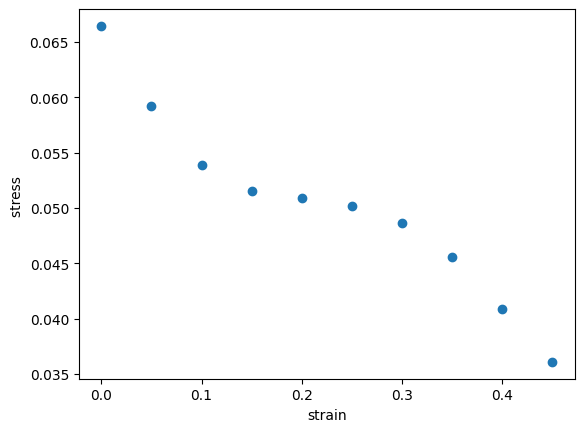

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(strains,stresses,'o')
plt.xlabel('strain')
plt.ylabel('stress')

In [ ]:
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.core.kpoints import Kpoints3D
jid = 'JVASP-816'
dat = get_jid_data(jid=jid,dataset='dft_3d')
atoms = Atoms.from_dict(dat['atoms'])
atoms = atoms.get_conventional_atoms
ase_atoms = (atoms.get_conventional_atoms).ase_converter()
kp = Kpoints3D().automatic_length_mesh(
    #lattice_mat=atoms.lattice_mat,
    #length=10
    lattice_mat=atoms.lattice_mat, length=dat["kpoint_length_unit"]
)
kpts = kp._kpoints[0]



Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 18.0MiB/s]


Loading the zipfile...
Loading completed.


In [ ]:
kpts

[17, 17, 17]

In [ ]:
ase_atoms

Atoms(symbols='Al4', pbc=True, cell=[4.06741, 4.06741, 4.06741])

In [ ]:
%%time
# Sample calculation from https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/structureoptimization/aluminium/aluminium.html
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW



calc = GPAW(mode=PW(500),       # cutoff
            kpts=kpts,     # k-points
            txt=name + '.txt')  # output file

ase_atoms.calc = calc

energy = ase_atoms.get_potential_energy()
#calc.write(name + '.gpw')
print('Energy:', energy, 'eV')

Energy: -16.655990977511557 eV
CPU times: user 2min 25s, sys: 1min 32s, total: 3min 58s
Wall time: 2min 56s


In [ ]:
%%time
import numpy as np
from ase.eos import calculate_eos
dx=np.arange(-0.05, 0.05, 0.01)
eos = calculate_eos(ase_atoms)
v, e, B = eos.fit()


In [ ]:
from ase.units import kJ
kv = B / kJ * 1.0e24
kv

83.74848683933646

# 3. Calculation of electronic band structure for Silicon

In [ ]:
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac

# Perform standard ground state calculation (with plane wave basis)
si = bulk('Si', 'diamond', 5.43)
calc = GPAW(mode=PW(200),
            xc='PBE',
            kpts=(8, 8, 8),
            random=True,  # random guess (needed if many empty bands required)
            occupations=FermiDirac(0.01),
            txt='Si_gs.txt')
si.calc = calc
si.get_potential_energy()
ef = calc.get_fermi_level()
calc.write('Si_gs.gpw')

In [ ]:
# Restart from ground state and fix potential:
calc = GPAW('Si_gs.gpw').fixed_density(
    nbands=16,
    symmetry='off',
    kpts={'path': 'GXWKL', 'npoints': 60},
    convergence={'bands': 8})


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  23.6.1
 |___|_|             

User:   ???@e91e90618716
Date:   Wed Aug  2 19:31:15 2023
Arch:   x86_64
Pid:    176
CWD:    /content
Python: 3.10.12
gpaw:   /usr/local/lib/python3.10/dist-packages/gpaw
_gpaw:  /usr/local/lib/python3.10/dist-packages/
        _gpaw.cpython-310-x86_64-linux-gnu.so
ase:    /usr/local/lib/python3.10/dist-packages/ase (version 3.22.1)
numpy:  /usr/local/lib/python3.10/dist-packages/numpy (version 1.22.4)
scipy:  /usr/local/lib/python3.10/dist-packages/scipy (version 1.10.1)
libxc:  5.1.7
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 8}
  gpts: [14 14 14]
  kpts: {npoints: 60,
         path: GXWKL}
  mode: {ecut: 200.0,
         name: pw}
  nbands: 16
  occupations: {name: fermi-dirac,
                width: 0.01}
  random: True
  symmetry: off
  xc: PBE

Initialize ...

species:
  Si:
    name: Silicon
    id:

<Axes: ylabel='energies [eV]'>

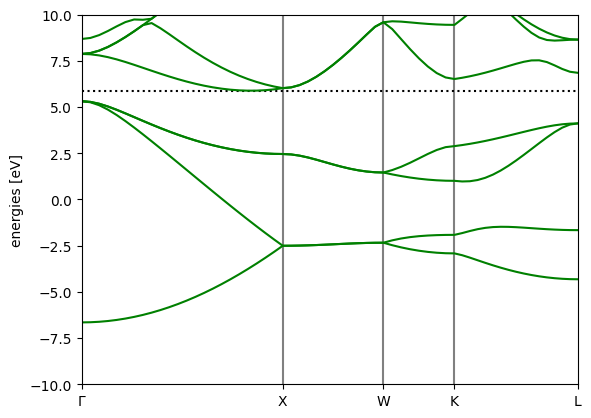

In [ ]:
%matplotlib inline
bs = calc.band_structure()
bs.plot(filename='bandstructure.png', show=False, emax=10.0)

#4. JARVIS-Leaderboard contribution

In [ ]:
%%time
# Source: https://github.com/usnistgov/jarvis_leaderboard/blob/main/jarvis_leaderboard/contributions/gpaw_lda/run.py
import pandas as pd
from gpaw import GPAW, PW, FermiDirac
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.core.kpoints import Kpoints3D
import time
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
#source: https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/electronic/band_gap/band_gap.html


def get_band_gap(atoms=None, cutoff=500,kpts=[7,7,7],xc='LDA'):
    calc = GPAW(mode=PW(cutoff),
                xc=xc,
                kpts=kpts,  # Choose and converge carefully!
                occupations=FermiDirac(0.01),
                txt='gs.out')
    atoms.calc = calc
    atoms.get_potential_energy()
    # Calculate the discontinuity potential and the discontinuity
    homo, lumo = calc.get_homo_lumo()
    efermi = calc.get_fermi_level()
    bandgap=lumo-homo
    # response = calc.hamiltonian.xc.response
    #dxc_pot = response.calculate_discontinuity_potential(homo, lumo)
    # KS_gap, dxc = response.calculate_discontinuity(dxc_pot)

    # Fundamental band gap = Kohn-Sham band gap + derivative discontinuity
    #QP_gap = KS_gap + dxc

    print('Band gap', bandgap)
    print('Fermi level', efermi)
    #print(f'Discontinuity from GLLB-sc: {dxc:.2f} eV')
    #print(f'Fundamental band gap:       {QP_gap:.2f} eV')
    return bandgap

dat = get_jid_data(jid='JVASP-1002',dataset='dft_3d')
silicon = Atoms.from_dict(dat['atoms'])
ase_atoms=silicon.ase_converter()
kp = Kpoints3D().automatic_length_mesh(

    lattice_mat=dat['atoms']['lattice_mat'],
    length=dat["kpoint_length_unit"],
)
kpts = kp._kpoints[0]
t1=time.time()
KS_gap = get_band_gap(atoms=ase_atoms,kpts=kpts)
t2=time.time()
print('Time', t2-t1)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:04<00:00, 9.30MiB/s]


Loading the zipfile...
Loading completed.


In [ ]:
f=open('ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv','w')
f.write('id,prediction\n')
line=jid+','+str(KS_gap)+'\n'
f.write(line)
f.close()

In [ ]:
!zip ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv.zip ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv

You can download the zip file by clicking on the folder icon on the left side of this notebook

# Now you can

1) [Fork](https://github.com/usnistgov/jarvis_leaderboard/fork) the jarvis-leaderboard GitHub repository

2) Add a new folder in the `jarvis_leaderboard/jarvis_leaderboard
/contributions/` folder, e.g., `gpaw_lda_test`

3) In the folder, add the `ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv.zip` file, an example `metadata.json` file, e.g. [this](https://github.com/usnistgov/jarvis_leaderboard/blob/main/jarvis_leaderboard/contributions/gpaw_lda/metadata.json) one, add a `run.sh` file, e.g. this [one](https://github.com/usnistgov/jarvis_leaderboard/blob/main/jarvis_leaderboard/contributions/gpaw_lda/run.sh)

4) Make a pull request from your forked repo to the main jarvis-leaderboard

# 5. A quick calculation of Al(111)-Al2O3(001) interface energy

In [ ]:
import os
import numpy as np
from jarvis.analysis.interface.zur import make_interface
from jarvis.analysis.defects.surface import Surface
from gpaw import GPAW, PW

def jarvis_atoms_to_energy(atoms=None,kp=[2,2,1],xc='PBE',ecut=300):
       name='jarvis_db_gpaw'
       calc = GPAW(mode=PW(ecut),       # cutoff
            kpts=kp,     # k-points
            txt=name + '.txt')
       ase_atoms=atoms.ase_converter()
       ase_atoms.calc=calc
       atoms_en = ase_atoms.get_potential_energy()
       return atoms_en

def get_interface_energy(
    film_atoms=None,
    subs_atoms=None,
    film_index=[1, 1, 1],
    subs_index=[0, 0, 1],
    film_thickness=25,
    subs_thickness=25,
    model_path="",
    seperation=3.0,
    vacuum=8.0,
    max_area_ratio_tol=1.00,
    max_area=500,
    ltol=0.05,
    atol=1,
    apply_strain=False,
    from_conventional_structure=True,
):
    film_surf = Surface(
        film_atoms,
        indices=film_index,
        from_conventional_structure=from_conventional_structure,
        thickness=film_thickness,
        vacuum=vacuum,
    ).make_surface()
    subs_surf = Surface(
        subs_atoms,
        indices=subs_index,
        from_conventional_structure=from_conventional_structure,
        thickness=subs_thickness,
        vacuum=vacuum,
    ).make_surface()
    het = make_interface(
        film=film_surf,
        subs=subs_surf,
        seperation=seperation,
        vacuum=vacuum,
        max_area_ratio_tol=max_area_ratio_tol,
        max_area=max_area,
        ltol=ltol,
        atol=atol,
        apply_strain=apply_strain,
    )
    film_en = jarvis_atoms_to_energy(het["film_sl"])
    print('film_en', film_en)
    subs_en = jarvis_atoms_to_energy(het["subs_sl"])
    print ('subs_en', subs_en)
    intf_en = jarvis_atoms_to_energy(het["interface"])
    print('intf_en', intf_en)

    m = het["interface"].lattice.matrix
    area = np.linalg.norm(np.cross(m[0], m[1]))
    intf_energy = 16 * (intf_en - subs_en - film_en) / (area)  # J/m2
    het["interface_energy"] = intf_energy
    return het




It might take more than a hour

In [ ]:
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
atoms_al = Atoms.from_dict(
    get_jid_data(dataset="dft_3d", jid="JVASP-816")["atoms"]
)
atoms_al2o3 = Atoms.from_dict(
    get_jid_data(dataset="dft_3d", jid="JVASP-32")["atoms"]
)
intf = get_interface_energy(
    film_atoms=atoms_al, subs_atoms=atoms_al2o3, film_thickness=10, subs_thickness=10
)
print(intf["interface_energy"] )


Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
mismatch_u,mismatch_v 0.03706886202229698 0.03706805926123646


/usr/local/lib/python3.7/site-packages/jarvis/core/atoms.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
  ) / bottom.lattice_mat[1][1]


film_en -140.35238830139863
subs_en -440.90161284833647
intf_en -587.6015482599141
-1.2706412219766434
